# Classifier Optimization


In earlier notebooks, we explored classification and feature selection techniques. Throughout, we have emphasized the importance of using cross-validation to measure classifier performance and to perform feature selection. We introduced the [Pipeline package](http://scikit-learn.org/stable/modules/pipeline.html#pipeline) to help facilitate this cross-validation process. During the past exercises we didn't pay much attention to the parameters of the classifier and set them arbitrarily or based on intuition. Biased selection measures are problematic and can lead to circular inferences (aka [double dipping](http://www.nature.com/doifinder/10.1038/nn.2303)). In what follows we are going to investigate data-driven, unbiased techniques to optimize classification parameters such as choice of classifiers, cost parameters, and classification penalties. We will again use the Pipeline package to perform this optimization.

We will be using the useful features from scikit-learn to perform cross-validation. scikit-learn also offers a simple procedure for building and automating the various steps involved in classifier optimization (e.g. data scaling => feature selection => parameter tuning). We will also explore these methods in this exercise.

## Goal of this script
1. Learn to detect and avoid circularity.
2. Build a pipeline of steps to optimize classifier performance.    
3. Use the pipeline to make an optimal classifier.  


## Table of Contents
[1. Load the data](#load-data)  

[2. Circular Inference: How to avoid double dipping](#double_dipping)  
>[2.1 Error: Voxel selection on all the data](#example-dd-vox-sel)  
>[2.2 Test: Verify procedure on random (permuted) labels](#example-dd-random)
  
[3. Cross-validation: Hyper-parameter selection and regularization](#cross_val) 
>[3.1 Grid Search](#grid_search)  
>[3.2 Regularization: L2 vs L1](#reg)  
>[3.3 Nested Cross-validation: Hyper-parameter selection](#nested_cross_val)   


[4. Make a pipeline](#pipeline)  

Exercises
>[Exercise 1](#ex1)  [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)   [7](#ex7)   

[Novel contribution](#novel)  

**Dataset:** For this script we will use a localizer dataset from [Kim et al. (2017)](https://doi.org/10.1523/JNEUROSCI.3272-16.2017) again. Just to recap: The localizer consisted of 3 runs with 5 blocks of each category (faces, scenes and objects) per run. Each block was presented for 15s. Within a block, a stimulus was presented every 1.5s (1 TR). Between blocks, there was 15s (10 TRs) of fixation. Each run was 310 TRs. In the matlab stimulus file, the first row codes for the stimulus category for each trial (1 = Faces, 2 = Scenes, 3 = Objects). The 3rd row contains the time (in seconds, relative to the start of the run) when the stimulus was presented for each trial.




In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
# Import fMRI and general analysis libraries
import nibabel as nib
import numpy as np
import scipy.io
from scipy import stats
import pandas as pd

# Import plotting library
import matplotlib.pyplot as plt
import seaborn as sns

# Import machine learning libraries
from nilearn.input_data import NiftiMasker
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, f_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from scipy.stats import sem
from copy import deepcopy

np.random.seed(0)
%matplotlib inline 
sns.set(style = 'white', context='notebook', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

In [2]:
# Load some helper functions
from utils import load_labels, load_data, blockwise_sampling, label2TR, shift_timing, reshape_data
from utils import normalize, decode
# Load some constants
from utils import vdc_data_dir, vdc_all_ROIs, vdc_label_dict, vdc_n_runs, vdc_hrf_lag, vdc_TR, vdc_TRs_run

np.random.seed(0)
print('Here are some constants specific to the VDC data:')
print(f'data dir = {vdc_data_dir}')
print(f'ROIs = {vdc_all_ROIs}')
print(f'Labels = {vdc_label_dict}')
print(f'number of runs = {vdc_n_runs}')
print(f'1 TR = {vdc_TR} sec')
print(f'HRF lag = {vdc_hrf_lag} sec')
print(f'num TRs per run = {vdc_TRs_run}')

Here are some constants specific to the VDC data:
data dir = /gpfs/gibbs/project/cmhn/data/vdc/
ROIs = ['FFA', 'PPA']
Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects'}
number of runs = 3
1 TR = 1.5 sec
HRF lag = 4.5 sec
num TRs per run = 310


## 1. Load the data <a id="load-data"></a>

Load the data for one participant using the helper functions.

In [3]:
sub_id = 8
mask_name = 'PPA' # This is set in order to reduce memory demands in order to run within 4Gb, however, if you want to make this run on whole brain, then set this to ''

In [4]:
# Specify the subject name
sub = f'sub-{sub_id:02d}' 

# Convert the shift into TRs
shift_size = int(vdc_hrf_lag / vdc_TR)  

# Load subject labels
stim_label_allruns = load_labels(vdc_data_dir, sub)

# Load run_ids
run_ids_raw = stim_label_allruns[5,:] - 1 

# Load the fMRI data using a mask
epi_mask_data_all = load_data(vdc_data_dir, sub, mask_name=mask_name)[0]

# This can differ per participant
print(f'{sub} data has {epi_mask_data_all.shape[1]} TRs and {epi_mask_data_all.shape[0]} voxels')
TRs_run = int(epi_mask_data_all.shape[1] / vdc_n_runs)

# Convert the timing into TR indexes
stim_label_TR = label2TR(stim_label_allruns, vdc_n_runs, vdc_TR, TRs_run)

# Shift the data some amount
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

# Perform the reshaping of the data
bold_data_raw, labels_raw = reshape_data(stim_label_TR_shifted, epi_mask_data_all)

# Normalize raw data within each run
bold_normalized_raw = normalize(bold_data_raw, run_ids_raw)

# Down sample the data to be blockwise rather than trialwise. 
# We'll use the blockwise data for all the following exercises
bold_data, labels, run_ids = blockwise_sampling(bold_data_raw, labels_raw, run_ids_raw)

# Normalize blockwise data within each run
bold_normalized = normalize(bold_data, run_ids)

Loaded sub-08
Processing Start ...
Loaded PPA mask
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-08/preprocessed/loc/sub-08_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-08/preprocessed/loc/sub-08_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-08/preprocessed/loc/sub-08_filtered2_d1_firstExampleFunc_r3.nii
sub-08 data has 933 TRs and 2937 voxels
Expected blocks: 45; Resampled blocks: 45


## 2. Circular Inference: How to avoid double dipping <a id="double_dipping"></a>

The `GridSearchCV` method that you will learn about below makes it easy (though not guaranteed) to avoid double dipping. In previous exercises, we examined cases where double dipping is clear (e.g., training on all of the data and testing on a subset). However, double dipping can be subtler and harder to detect, such as in situations where you perform feature selection on the entire dataset before classification (as in last week's notebook).

We now examine some cases of double dipping again. This is a critically important issue for doing fMRI analysis correctly and for obtaining generalizable results. We would like to emphasize through these examples:
> 1. Whenever possible, _never_ look at your test data before building your model.
> 2. If you *do* build your model using test data, verify your model on random noise. Your model should report chance level performance. If not, something is wrong.

### 2.1 Common error: Voxel selection on all the data<a id="example-dd-vox-sel"></a>

Below we work through an exercise of a common type of double dipping: performing voxel selection on *all* of our data before splitting into training/testing datasets.

In [5]:
np.random.seed(0)
sp = PredefinedSplit(run_ids)
clf_score = []
for train, test in sp.split():
    
    # Do voxel selection on all voxels
    selected_voxels = SelectKBest(f_classif,k=100).fit(bold_normalized, labels)
    
    # Pull out the sample data
    train_data = bold_normalized[train, :]
    test_data = bold_normalized[test, :]

    # Train and test the classifier
    classifier = SVC(kernel="linear", C=1)
    clf = classifier.fit(selected_voxels.transform(train_data), labels[train])
    score = clf.score(selected_voxels.transform(test_data), labels[test])
    clf_score.append(score) 

print('Classification accuracy:', np.mean(clf_score))

Classification accuracy: 0.888888888888889


### 2.2 Test: Verify procedure on random (permuted) labels<a id="example-dd-random"></a>

One way to check if the procedure is valid is to test it on random data. We can do this by randomly assigning labels to every block. This breaks the true connection between the labels and the brain data, meaning that there should be **no** basis for reliable classification. So, if the classifier accuracy is above chance using permuted labels, we have done something wrong. Here, we apply our selection method and assess classifier accuracy. 

In [6]:
np.random.seed(0)
n_iters = 10  # How many permutations will we run? 
sp = PredefinedSplit(run_ids)
clf_score = []

for i in range(n_iters):
    clf_score_i = []
    
    # Permute our labels to break the structure between brain data and labels
    permuted_labels = np.random.permutation(labels)
    
    for train, test in sp.split():
        # Do voxel selection on all voxels
        selected_voxels = SelectKBest(f_classif,k=100).fit(bold_normalized, labels)

        # Pull out the sample data
        train_data = bold_normalized[train, :]
        test_data = bold_normalized[test, :]

        # Train and test the classifier
        classifier = SVC(kernel="linear", C=1)
        clf = classifier.fit(selected_voxels.transform(bold_normalized), permuted_labels)
        score = clf.score(selected_voxels.transform(test_data), permuted_labels[test])
        clf_score_i.append(score)
    clf_score.append(np.mean(clf_score_i))
        
print (f'Mean classification across {n_iters} folds: {np.mean(clf_score)}')
print (f'Standard error: {sem(clf_score)}')
print (f'Chance level: {np.round(1/3,3)}')

Mean classification across 10 folds: 1.0
Standard error: 0.0
Chance level: 0.333


<div class="alert alert-block alert-warning">
<strong>We see above chance decoding accuracy! Something is wrong.</strong>
</div>

**Exercise 1:**<a id="ex1"></a> Describe the double-dipping in the above code. Then, rewrite the code to fix the concerns and verify that accuracy on permuted test data is at chance level.   

**A:** 
voxel selection was done on the entire dataset, not just the training dataset. SelectKBest(f_classif,k=100).fit(bold_normalized, labels) uses bold_normalized and labels, both of which cover both the training and testing. In addition, the classifier was trained on the entire dataset as well in clf = classifier.fit(selected_voxels.transform(bold_normalized), permuted_labels)

In [7]:
# Insert code here
np.random.seed(0)
sp = PredefinedSplit(run_ids)
clf_score = []
for train, test in sp.split():
    
    # Do voxel selection on all voxels
    selected_voxels = SelectKBest(f_classif,k=100).fit(bold_normalized[train, :], labels[train])
    
    # Pull out the sample data
    train_data = bold_normalized[train, :]
    test_data = bold_normalized[test, :]

    # Train and test the classifier
    classifier = SVC(kernel="linear", C=1)
    clf = classifier.fit(selected_voxels.transform(train_data), labels[train])
    score = clf.score(selected_voxels.transform(test_data), labels[test])
    clf_score.append(score) 

print('Classification accuracy:', np.mean(clf_score))

Classification accuracy: 0.9111111111111111


In [8]:
np.random.seed(0)
n_iters = 10  # How many permutations will we run? 
sp = PredefinedSplit(run_ids)
clf_score = []

for i in range(n_iters):
    clf_score_i = []
    
    # Permute our labels to break the structure between brain data and labels
    permuted_labels = np.random.permutation(labels)
    
    for train, test in sp.split():
        # Do voxel selection on all voxels
        selected_voxels = SelectKBest(f_classif,k=100).fit(bold_normalized[train, :], labels[train])

        # Pull out the sample data
        train_data = bold_normalized[train, :]
        test_data = bold_normalized[test, :]

        # Train and test the classifier
        classifier = SVC(kernel="linear", C=1)
        clf = classifier.fit(selected_voxels.transform(bold_normalized[train, :]), permuted_labels[train])
        score = clf.score(selected_voxels.transform(test_data), permuted_labels[test])
        clf_score_i.append(score)
    clf_score.append(np.mean(clf_score_i))
        
print (f'Mean classification across {n_iters} folds: {np.mean(clf_score)}')
print (f'Standard error: {sem(clf_score)}')
print (f'Chance level: {np.round(1/3,3)}')

Mean classification across 10 folds: 0.33777777777777784
Standard error: 0.02496636969830032
Chance level: 0.333


<div class="alert alert-block alert-info">
<strong> Sometimes you don't want to perform Leave-One-Run-Out </strong>
<br>
If we have different runs (or even a single run) but don't want to use them as the basis for your training/test splits (for instance, because we think that participants may respond differently on later vs. earlier runs; or we have only one run in the experiment in which we show a long movie), we can run into double dipping issues. For example, if you only have one run, it can still be useful to z-score each voxel (over time) within that run. Without z-scoring, voxels may have wildly different scales due to scanner drift or other confounds, distorting the classifier. Hence we need to normalize within run but this could be considered double dipping because each run includes both training and test data.  In these circumstances, it may (or may not) be fine to z-score over the entire dataset. <strong>Always verify the model performance by randomizing the labels!</strong>
</div>

## 3. Cross-Validation: Hyperparameter selection and regularization <a id="cross_val"></a>


Each of the classifiers we have used so far has one or more "hyperparameters" used to configure and optimize the model based on the data and our goals. For instance, regularized logistic regression has a "penalty" hyperparameter which determines how much to emphasize the weight regularizing expression (e.g., L2 norm) when training the model. For an explanation on the distinction between hyperparameters and parameters, read [this Machine Learning Mastery Article](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/). 

**Exercise 2:** <a id="ex2"></a> SVM has a "cost" ('C') hyperparameter, a.k.a. soft-margin hyperparameter. Look this up and briefly describe what it means. 

**A:**  

The cost hyperparameter, C, determines the penalty for misclassifying data points during algorithm training. 

When C is small, the SVM model is more tolerant of misclassified data points. This is called a soft margin and has results that may be underfitting the data. 

When C is large, the SVM model is less tolerant of misclassified data points. This is called a hard margin and has results that may be overfitting the data.

## 3.1 Grid Search <a id="grid_search"></a>


We want to pick the best cost hyperparameter for our dataset. To do this while avoiding double dipping, we can use cross-validation. Hyperparameters are often (but not always) continuous variables. Each hyperparameter can be considered as a dimension such that the set of hyperparameters is a space to be searched for effective values. The `GridSearchCV` method in [scikit-learn](http://scikit-learn.org/stable/modules/grid_search.html#grid-search) explores the hyperparameter space by dividing it up into a grid of values to be searched exhaustively. 

To give you an intuition for how grid search works, imagine trying to figure out the climate you find most comfortable. Assume there are two (hyper)parameters that seem relevant -- temperature and humidity -- and a given climate can be defined by the combination of temperature and humidity values. A grid search would involve changing the value of each parameter with respect to the other in some fixed step size (e.g., 60 degrees and 50% humidity, 60 degrees and 60% humidity, 65 degrees and 60% humidity, etc.) and evaluating your preference for each combination.  

Note that the number of steps and hyperparameters to search is up to you. But be aware of combinatorial explosion: the granularity of the search (the smaller the steps) and the number of hyperparameters considered increases the search time exponentially.

`GridSearchCV` is an *extremely* useful tool for hyperparameter optimization because it is very flexible. You can look at different values of a hyperparameter, different [kernels](http://scikit-learn.org/stable/modules/svm.html), different training/test split sizes, etc. The input to the function is a dictionary where the key is the parameter of interest (the sides of the grid) and the values are the parameter increments to search over (the steps of the grid).

Below we are going to do a grid search over the SVM cost `C` hyperparameter (we call it a grid search now, even though only a single dimension is being searched over) and investigate the results. The output contains information about the best hyperparameter.

In [9]:
# Search over different cost parameters (C)
np.random.seed(0)
parameters = {'C':[0.01, 0.1, 1, 10]}
clf = GridSearchCV(
    SVC(kernel='linear'),
    parameters,
    cv=PredefinedSplit(run_ids),
    return_train_score=True
)
clf.fit(bold_normalized, labels)

# What was the best classifier and cost?
print(f'The best model: {clf.best_estimator_}')  
# What was the best classification score?
print(f'The score of the best model: {clf.best_score_}')  

The best model: SVC(C=0.01, kernel='linear')
The score of the best model: 0.8666666666666667


Want to see more details from the cross-validation? All the results are stored in the dictionary `cv_results_`. Let's took a look at some of the important metrics stored here. For more details you can look at the `cv_results_` method on [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

You can print out `cv_results_` directly or for a nicer look you can import it into a [pandas dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) and print it out. Each row corresponds to one parameter combination.

([Pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) is a widely used data processing and machine learning package. Many of the functions work similarly to R, and it plays *very* nicely with [Seaborn](https://seaborn.pydata.org/) plotting package.)

In [10]:
# Ugly way
print(clf.cv_results_)

{'mean_fit_time': array([0.00297817, 0.00270534, 0.00267037, 0.00265185]), 'std_fit_time': array([2.91939199e-05, 6.73863307e-05, 2.14314595e-05, 2.92218150e-06]), 'mean_score_time': array([0.00112518, 0.00100732, 0.00097966, 0.00098149]), 'std_score_time': array([3.47994946e-05, 4.38677228e-05, 1.52040533e-06, 8.15362106e-06]), 'param_C': masked_array(data=[0.01, 0.1, 1, 10],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}], 'split0_test_score': array([0.93333333, 0.93333333, 0.93333333, 0.93333333]), 'split1_test_score': array([0.93333333, 0.93333333, 0.93333333, 0.93333333]), 'split2_test_score': array([0.73333333, 0.73333333, 0.73333333, 0.73333333]), 'mean_test_score': array([0.86666667, 0.86666667, 0.86666667, 0.86666667]), 'std_test_score': array([0.0942809, 0.0942809, 0.0942809, 0.0942809]), 'rank_test_score': array([1, 1, 1, 1], dtype=int32), 'split0_train_score': array([1

In [11]:
# Nicer way (using pandas)
results = pd.DataFrame(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.002978,0.000029,0.001125,0.000035,0.01,{'C': 0.01},0.933333,0.933333,0.733333,0.866667,0.094281,1,1.0,1.0,1.0,1.0,0.0
1,0.002705,0.000067,0.001007,0.000044,0.1,{'C': 0.1},0.933333,0.933333,0.733333,0.866667,0.094281,1,1.0,1.0,1.0,1.0,0.0
2,0.002670,0.000021,0.000980,0.000002,1,{'C': 1},0.933333,0.933333,0.733333,0.866667,0.094281,1,1.0,1.0,1.0,1.0,0.0
3,0.002652,0.000003,0.000981,0.000008,10,{'C': 10},0.933333,0.933333,0.733333,0.866667,0.094281,1,1.0,1.0,1.0,1.0,0.0


We are now going to do some different types of cross-validation hyperparameter tuning.

**Exercise 3:**<a id="ex3"></a> In machine learning, kernels are classes of algorithms that can be used to create a model. The (Gaussian) radial basis function (RBF) kernel is very common for SVM classifiers. Look up the RBF kernel and describe what it does. Also describe its parameter gamma. 

**A:**  

The RBF kernel computes a similarity measure between pairs of input data points by measuring the distance between them in a high-dimensional space. The kernel function assigns a higher weight to points that are close to each other and a lower weight to points that are far apart.

The parameter controls the width of the kernel. It determines the extent to which the kernel function will be influenced by the distance between data points. 

When gamma is large, the kernel function will consider only data points that are very close to each other, resulting in a complex model with a high risk of overfitting. On the other hand.

When gamma is small, the kernel function will consider a wider range of data points, resulting in a simpler model with a higher risk of underfitting.

**Exercise 4:**<a id="ex5"></a> When would linear SVM be expected to outperform other kernels and why? Run an analysis in which you compare linear, polynomial, and RBF kernels for SVM using GridSearchCV. Print out the best parameters chosen by GridSearchCV using `clf.best_params_`.   

*Hint*: You should not run 3 separate calls to GridSearchCV; you should treat these kernels as different hyperparameters to fit, along with `C = [10e-3, 10e0, 10e2]` and `gamma = [10e-3, 10e0, 10e2]`. 

**A:**  
Linear models are best for simpler, more linearally separable data that can be classified between relatively well without overfitting.

In [12]:
# Code here
np.random.seed(0)
parameters = {'C':[0.01, 0.1, 1, 10], 'kernel':['linear', 'polynomial', 'RBF'], 'gamma':[10e-3, 10e0, 10e2]}
clf = GridSearchCV(
    SVC(),
    parameters,
    cv=PredefinedSplit(run_ids),
    return_train_score=True
)
clf.fit(bold_normalized, labels)

# What was the best classifier and cost?
print(f'The best model: {clf.best_estimator_}')  
# What was the best classification score?
print(f'The score of the best model: {clf.best_score_}')  

The best model: SVC(C=0.01, gamma=0.01, kernel='linear')
The score of the best model: 0.8666666666666667


### 3.2 Regularization Example: L1 vs. L2 <a id="reg"></a>

Regularization is a technique that helps to reduce overfitting by assigning a penalty to the weights learned by the model. One common classifier used is [logistic regression](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc), which features different regularization options including the L1 and L2 penalties. An L1 (also called lasso) penalty penalizes the sum of the absolute values of the weights, whereas an L2 (also called ridge) penalty penalizes the sum of the squares of the weights. The L1 penalty leads to a sparser set of weights, with some high and the rest close to zero. The L2 penalty results in very small, nonzero weights. A more detailed explanation of (L2 and L1) regularization can be found [here](https://www.kaggle.com/residentmario/l1-norms-versus-l2-norms).

Below, we compare the L1 and L2 penalties for logistic regression. For each of the penalty types, we run 3 folds and compute the correlation of weights across folds. If the weights on each voxel are similar across folds, then that can be thought of as a stable model. A higher correlation means a more stable model.


In [13]:
# Compare L1 and L2 regularization in logistic regression
np.random.seed(0)
# Decode with L1 regularization
logreg_l1 = LogisticRegression(penalty='l1', solver = 'liblinear')
model_l1, score_l1 = decode(bold_normalized, labels, run_ids, logreg_l1)
print('Accuracy with L1 penalty: ', score_l1)

# Decode with L2 regularization
logreg_l2 = LogisticRegression(penalty='l2', solver = 'liblinear')
model_l2, score_l2 = decode(bold_normalized, labels, run_ids, logreg_l2)
print('Accuracy with L2 penalty: ', score_l2)
print(f'StDev of scores with L1: {np.std(score_l1)} | StDev of scores with L2: {np.std(score_l2)}')

Accuracy with L1 penalty:  [0.8666666666666667, 1.0, 0.7333333333333333]
Accuracy with L2 penalty:  [0.8, 0.8666666666666667, 0.8666666666666667]
StDev of scores with L1: 0.10886621079036349 | StDev of scores with L2: 0.03142696805273544


From this, you can see the L1 penalty achieves a higher accuracy on 2/3 folds, but the standard deviation of those scores is 3x greater than with L2 - indicating its weights may be less stable.

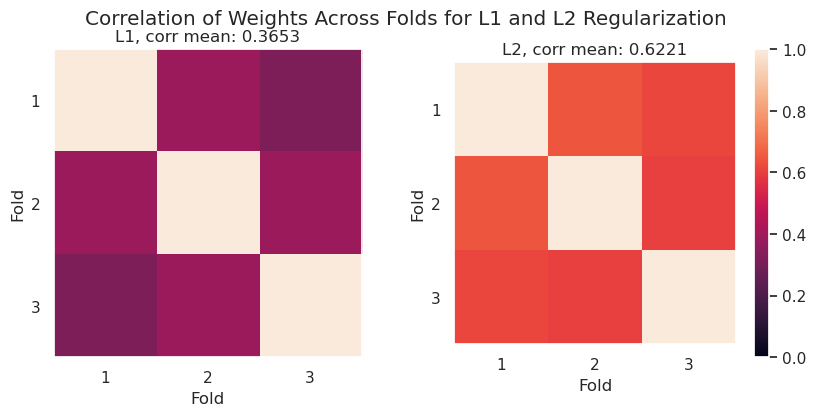

In [14]:
# Pull out the weights for the 3 folds of the different types of regularization
wts_l1 = np.stack([(model_l1[i].coef_).flatten() for i in range(len(model_l1))])
wts_l2 = np.stack([(model_l2[i].coef_).flatten() for i in range(len(model_l2))])

# Correlate the weights across each fold with the other folds
corr_l1 = np.corrcoef(wts_l1)
corr_l2 = np.corrcoef(wts_l2)

# Plot the correlations across the folds
fig,axes=plt.subplots(1,2,figsize=(10,4))
plt.suptitle('Correlation of Weights Across Folds for L1 and L2 Regularization')

axes[0].imshow(corr_l1, vmin=0, vmax=1)
pos=[0,1,2]
lab=['1','2','3']
axes[0].set_title('L1, corr mean: %0.4f' % np.mean(corr_l1[np.triu(corr_l1, 1) > 0]))
axes[0].set_xticks(pos,lab)
axes[0].set_yticks(pos,lab)
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Fold')
axes[0].grid(False)

im=axes[1].imshow(corr_l2, vmin=0, vmax=1)
pos=[0,1,2]
lab=['1','2','3']
axes[1].set_title('L2, corr mean: %0.4f' % np.mean(corr_l2[np.triu(corr_l2, 1) > 0]))
axes[1].set_xticks(pos,lab)
axes[1].set_yticks(pos,lab)
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Fold')
axes[1].grid(False)
fig.colorbar(im)

**Exercise 5**:<a id="ex5"></a>  The L2 weights have a stronger correlation across folds. Why does L2 lead to more stable weights across folds?   
*Hint*: Consider how L1 and L2 penalties would affect the weights assigned to two or more voxels that carry highly corrrelated information.

**A:**  
L1 results in a sparser dataset and so as you increase the L1 penalty, some weights will go down to 0. L2 never gets rid of features entirely, it will only shrink them. So while in L1 some weights will be chosen and lowered to 0 instead of others, L2 will lower similar features weights down together, leading to more stable weights across folds.

<div class="alert alert-block alert-info">
You might be tempted to run grid search CV, find the best result, and then report that result in your paper. The right way to handle this issue is to validate the model on unseen data, a procedure known as nested cross-validation.
</div>

### 3.3 Nested cross-validation: Hyperparameter selection <a id='nested_cross_val'></a>   


When we are writing a classification pipeline, nested cross-validation can be very useful. As the name suggests, this procedure nests a second cross-validation within folds of the first cross-validation. As before, we will divide data into training and test sets (outer loop), but additionally will divide the training set itself in order to set the hyperparameters into training and validation sets (inner loop).

Thus, on each split we now have a training (inner), validation (inner), and test (outer) dataset; we will use leave-one-run-out for the validation set in the inner loop. Within the inner loop we train the model and find the optimal hyperparameters (i.e., that have the highest performance when tested on the validation data). The typical practice is to then retrain your model with these hyperparameters on both the training AND validation datasets and then evaluate on your held-out test dataset to get a score.

![image](https://i.stack.imgur.com/vh1sZ.png)

This is turtles all the way down -- you could have any number of inner loops. However, you will run into data issues quickly (not enough data for training) and you will also run the risk of over-fitting your data: you will find the optimal parameters for a small set of your data but this might not generalize to the rest of your data. For more description and a good summary of what you have learned so far then check [here](https://www.elderresearch.com/blog/nested-cross-validation-when-cross-validation-isnt-enough/).

In [15]:
# Print out the training, validation, and testing set (the indexes that belong to each group)

# Outer loop:
# Split training (including validation) and testing set
sp = PredefinedSplit(run_ids)
for outer_idx, (train, test) in enumerate(sp.split()):
    train_run_ids = run_ids[train]
    print(f'Outer loop {outer_idx}:')
    print(f'Testing: {test}')
    
    # Inner loop (implicit, in GridSearchCV):
    # split training and validation set
    sp_train = PredefinedSplit(train_run_ids)
    for inner_idx, (train_inner, val) in enumerate(sp_train.split()):
        print(f'\tInner loop {inner_idx}:')
        print(f'\tTraining: {train[train_inner]}')
        print(f'\tValidation: {train[val]}')
    print()

Outer loop 0:
Testing: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
	Inner loop 0:
	Training: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
	Validation: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
	Inner loop 1:
	Training: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
	Validation: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]

Outer loop 1:
Testing: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
	Inner loop 0:
	Training: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
	Validation: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
	Inner loop 1:
	Training: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
	Validation: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]

Outer loop 2:
Testing: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
	Inner loop 0:
	Training: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
	Validation: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
	Inner loop 1:
	Training: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
	Validation: [15 16 17 18 19 20 21 22 23 24 25 26 

In [16]:
# Example of nested cross-validation using one subject and logistic regression

# Outer loop:
# Split training (including validation) and testing set
sp = PredefinedSplit(run_ids)
clf_score = []
C_best = []
for train, test in sp.split():
    
    # Pull out the sample data
    train_run_ids = run_ids[train]
    train_data = bold_normalized[train, :]
    test_data = bold_normalized[test, :]
    train_label = labels[train]
    test_label = labels[test]
    
    # Inner loop (implicit, in GridSearchCV):
    # Split training and validation set
    sp_train = PredefinedSplit(train_run_ids)
    
    # Search over different regularization parameters: smaller values specify stronger regularization.
    parameters = {'C':[10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1]}
    inner_clf = GridSearchCV(
        LogisticRegression(penalty='l2'),
        parameters,
        cv=sp_train,
        return_train_score=True)
    inner_clf.fit(train_data, train_label)
    
    # Find the best hyperparameter
    C_best_i = inner_clf.best_params_['C']
    C_best.append(C_best_i)
    
    # Train the classifier with the best hyperparameter using training and validation set
    classifier = LogisticRegression(penalty='l2', C=C_best_i)
    clf = classifier.fit(train_data, train_label)
    
    # Test the classifier
    score = clf.score(test_data, test_label)
    clf_score.append(score)
    
print ('Outer loop classification accuracy:', clf_score)
print ('Best cost value:', C_best)

Outer loop classification accuracy: [0.8666666666666667, 0.8666666666666667, 0.8]
Best cost value: [0.0001, 0.01, 0.001]


**Exercise 6:**<a id="ex6"></a> Set up a nested cross-validation loop for the PPA data of the first 3 subjects of the VDC data using SVM with a linear kernel. For each subject, use grid search to find the best hyperparameter C over the values `[10e-2, 10e-1, 10e0, 10e1]` in your inner loop. Report the best C for each run and the average and standard error of classification accuracies across folds, for each subject. 

Things to watch out for: 
- Be careful not to use hyperparameter optimization (e.g., with `GridSearchCV`) in both inner and outer loops of nested cross-validation
- As always: If in doubt, check the [scikit-learn documentation](http://scikit-learn.org/stable/index.html) or [StackExchange Community](https://stackexchange.com/) for help
- Running nested cross validation will take a couple of minutes. Grab a snack.
- Use different variable names than the ones used above (such as `bold_normalized`, `labels` and `run_ids`) since we will still be using those data later.


In [17]:
# Insert here

# Create a function that will load and prepare the blockwise BOLD data, event labels, and run ids
# for a single subject and ROI. 
# For inspiration, check out section 1: load data. You're going to use this function again later.
# Write docstring-style description of your function (see week 2 notebook if you forget!).

def load_single_subject_data(subject, ROI_name):
    # Specify the subject name
    subf = f'sub-{subject:02d}' 

    # Convert the shift into TRs
    shift_size = int(vdc_hrf_lag / vdc_TR)  

    # Load subject labels
    stim_label_allruns = load_labels(vdc_data_dir, subf)

    # Load run_ids
    run_ids_raw = stim_label_allruns[5,:] - 1 

    # Load the fMRI data using a mask
    epi_mask_data_all = load_data(vdc_data_dir, subf, mask_name=ROI_name)[0]

    # This can differ per participant
    print(f'{subf} data has {epi_mask_data_all.shape[1]} TRs and {epi_mask_data_all.shape[0]} voxels')
    TRs_run = int(epi_mask_data_all.shape[1] / vdc_n_runs)

    # Convert the timing into TR indexes
    stim_label_TR = label2TR(stim_label_allruns, vdc_n_runs, vdc_TR, TRs_run)

    # Shift the data some amount
    stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

    # Perform the reshaping of the data
    bold_data_raw, labels_raw = reshape_data(stim_label_TR_shifted, epi_mask_data_all)

    # Normalize raw data within each run
    bold_normalized_raw = normalize(bold_data_raw, run_ids_raw)

    # Down sample the data to be blockwise rather than trialwise. 
    bold_dataf, labelsf, run_idsf = blockwise_sampling(bold_data_raw, labels_raw, run_ids_raw)

    # Normalize blockwise data within each run
    bold_normalizedf = normalize(bold_dataf, run_idsf)
    return bold_normalizedf, labelsf, run_idsf

In [18]:
# Now code your nested cross-validation loops
np.random.seed(0)
subjects_exercise_6 = [1,2,3]

# Save results for all subjects
clf_accuracy_all_subjects, clf_Cs_all_subjects = [], []

# Loop through subjects
for sub in subjects_exercise_6:
    # Load data, labels, and run_ids for this subject
    fbold, flabels, frun_ids = load_single_subject_data(sub, "PPA")
    
    clfScores, clfCs = [], []
    
    ps = PredefinedSplit(frun_ids)
    # Create outer loop: Split data & labels into training and testing sets
    for train, test in ps.split():
        
        train_run_ids = frun_ids[train]
        
        train_data = fbold[train, :]
        test_data = fbold[test, :]
        
        train_label = flabels[train]
        test_label = flabels[test]
        
        # Create another split to divide training data into training/validation for inner loop
        sp_train = PredefinedSplit(train_run_ids)
        
        # Use grid search over the parameters you want to optimize
        parameters = {'C':[10e-2, 10e-1, 10e0, 10e1]}
        inner_clf = GridSearchCV(
        SVC(kernel='linear'),
        parameters,
        cv=sp_train,
        return_train_score=True)
        
        inner_clf.fit(train_data, train_label)
        
        # Grab the best parameter
        C_best_i = inner_clf.best_params_['C']
        clfCs.append(C_best_i)

        # Train the classifier using all training data and the best hyperparameters
        classifier = SVC(kernel="linear", C=C_best_i)
        clfs = classifier.fit(train_data, train_label)
        
        # Score the classifier on the test data and save
        score = clfs.score(test_data, test_label)
        clfScores.append(score)
    
    # Save results for this subject
    clf_accuracy_all_subjects.append(clfScores)
    clf_Cs_all_subjects.append(clfCs)

Loaded sub-01
Processing Start ...
Loaded PPA mask
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
sub-01 data has 930 TRs and 2504 voxels
Expected blocks: 45; Resampled blocks: 45
Loaded sub-02
Processing Start ...
Loaded PPA mask
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-02/preprocessed/loc/sub-02_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-02/preprocessed/loc/sub-02_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-02/preprocessed/loc/sub-02_filtered2_d1_firstExampleFunc_r3.nii
sub-02 data has 933 TRs and 3185 voxels
Expected blocks: 45; Resampled blocks: 45
Loaded sub-03


In [19]:
# Report the results
print(f'Results for exercise 6')
for s, subject in enumerate(subjects_exercise_6):
    print(f'Sub-{subject:02d} C:{clf_Cs_all_subjects[s]}, accuracy (mean,std): {np.mean(clf_accuracy_all_subjects[s])}, {np.std(clf_accuracy_all_subjects[s])}')
    

Results for exercise 6
Sub-01 C:[0.1, 0.1, 0.1], accuracy (mean,std): 0.7111111111111111, 0.03142696805273544
Sub-02 C:[0.1, 0.1, 0.1], accuracy (mean,std): 0.9333333333333332, 0.05443310539518172
Sub-03 C:[0.1, 0.1, 0.1], accuracy (mean,std): 0.7777777777777778, 0.1911627837120584


## 4. Build a Pipeline <a id="pipeline"></a>

In a previous notebook we had introduced the scikit-learn method, [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline), that simplified running a sequence steps in an automated fashion. We will now use the pipeline to do feature selection and cross-validation. Below we create a pipeline with the following steps:   
>Use PCA and choose the best option from a set of dimensions.  
>Choose the best cost hyperparameter value for an SVM.

It is then really easy to do cross-validation at different levels of this pipeline.

The steps below are based on [this example in scikit-learn](https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#illustration-of-pipeline-and-gridsearchcv).

In [20]:
# Set up the pipeline
pipe = Pipeline([
#         ('scale', preprocessing.StandardScaler()), # This could be part of our pipeline, but we already normalized our data.
        ('reduce_dim', PCA()),
        ('classify', SVC(kernel="linear")),
    ])

# PCA dimensions
component_steps = [10, 20, 30]

# Classifier cost options
c_steps = [10e-1, 10e0, 10e1, 10e2]

# Build the grid search dictionary
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)], 
        'reduce_dim__n_components': component_steps,
        'classify__C': c_steps,
    },
]

Now we are going to put it all together and run the pipeline

In [21]:
# Parallelization parameter, will return to this later...
n_jobs=1

clf_pipe = GridSearchCV(pipe,
                        cv=PredefinedSplit(run_ids),
                        n_jobs=n_jobs,
                        param_grid=param_grid,
                        return_train_score=True
                       )

clf_pipe.fit(bold_normalized, labels)  # Run the pipeline

print(clf_pipe.best_estimator_)  # What was the best classifier and parameters?
print(clf_pipe.best_score_)  # What was the best classification score?

# Sort results with declining mean test score
cv_results = pd.DataFrame(clf_pipe.cv_results_)
cv_results.sort_values(by='mean_test_score', ascending=False)

Pipeline(steps=[('reduce_dim', PCA(iterated_power=7, n_components=30)),
                ('classify', SVC(kernel='linear'))])
0.8666666666666667


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classify__C,param_reduce_dim,param_reduce_dim__n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,0.008797,0.000026,0.001050,0.000009,1.0,"PCA(iterated_power=7, n_components=30)",30,"{'classify__C': 1.0, 'reduce_dim': PCA(iterate...",0.933333,0.933333,0.733333,0.866667,0.094281,1,1.0,1.0,1.0,1.0,0.0
5,0.008563,0.000021,0.000989,0.000006,10.0,"PCA(iterated_power=7, n_components=30)",30,"{'classify__C': 10.0, 'reduce_dim': PCA(iterat...",0.933333,0.933333,0.733333,0.866667,0.094281,1,1.0,1.0,1.0,1.0,0.0
8,0.008463,0.000066,0.000973,0.000014,100.0,"PCA(iterated_power=7, n_components=30)",30,"{'classify__C': 100.0, 'reduce_dim': PCA(itera...",0.933333,0.933333,0.733333,0.866667,0.094281,1,1.0,1.0,1.0,1.0,0.0
11,0.008373,0.000009,0.000953,0.000002,1000.0,"PCA(iterated_power=7, n_components=30)",30,"{'classify__C': 1000.0, 'reduce_dim': PCA(iter...",0.933333,0.933333,0.733333,0.866667,0.094281,1,1.0,1.0,1.0,1.0,0.0
0,0.013675,0.000613,0.000984,0.000074,1.0,"PCA(iterated_power=7, n_components=30)",10,"{'classify__C': 1.0, 'reduce_dim': PCA(iterate...",0.800000,0.800000,0.600000,0.733333,0.094281,5,1.0,1.0,1.0,1.0,0.0
3,0.013083,0.000032,0.000936,0.000007,10.0,"PCA(iterated_power=7, n_components=30)",10,"{'classify__C': 10.0, 'reduce_dim': PCA(iterat...",0.800000,0.800000,0.600000,0.733333,0.094281,5,1.0,1.0,1.0,1.0,0.0
6,0.012690,0.000098,0.000861,0.000024,100.0,"PCA(iterated_power=7, n_components=30)",10,"{'classify__C': 100.0, 'reduce_dim': PCA(itera...",0.800000,0.800000,0.600000,0.733333,0.094281,5,1.0,1.0,1.0,1.0,0.0
9,0.012813,0.000099,0.000885,0.000014,1000.0,"PCA(iterated_power=7, n_components=30)",10,"{'classify__C': 1000.0, 'reduce_dim': PCA(iter...",0.800000,0.800000,0.600000,0.733333,0.094281,5,1.0,1.0,1.0,1.0,0.0
1,0.019966,0.000158,0.001013,0.000003,1.0,"PCA(iterated_power=7, n_components=30)",20,"{'classify__C': 1.0, 'reduce_dim': PCA(iterate...",0.800000,0.733333,0.600000,0.711111,0.083148,9,1.0,1.0,1.0,1.0,0.0
4,0.019630,0.000112,0.000975,0.000027,10.0,"PCA(iterated_power=7, n_components=30)",20,"{'classify__C': 10.0, 'reduce_dim': PCA(iterat...",0.800000,0.733333,0.600000,0.711111,0.083148,9,1.0,1.0,1.0,1.0,0.0


**Exercise 7:**<a id="ex7"></a> Build a pipeline that performs the following steps:

1. Voxel selection using the ANOVA method (`SelectKBest` and `f_classif`), optimizing the value `reduce_dim__k` with a grid search over `[10, 25, 50, 75, 100]`.
2. Grid search over the linear and RBF SVM kernels.

Run this pipeline for at least 5 subjects, in the FFA, and present your results as a bar graph with subjects on the x-axis and accuracy on the y-axis. Be sure to title this plot and add axis labels.

In [22]:
# Code here
np.random.seed(0)

# Set up the pipeline.
pipe = Pipeline([
    ('reduce_dim', SelectKBest()),
    ('classify', SVC()),
    ])

# Build the grid search dictionary.
k_steps = [10, 25, 50, 75, 100]
kernel_steps = ['linear', 'rbf']
param_grid = [{ 
    'reduce_dim__k': k_steps,
    'classify__kernel': kernel_steps
    }]

scores_all_subs = []
# Run the pipeline on each subject.
clf_accuracy_all_subjects = []
for sub in range(1, 6):
    # Load data, labels, and run_ids for this subject
    norm_data, classes, run_idx = load_single_subject_data(sub, 'FFA')
    
    # run CV on the pipeline
    n_jobs=1
    clf_pipe = GridSearchCV(
        pipe,
        cv=PredefinedSplit(run_idx),
        n_jobs=n_jobs,
        param_grid=param_grid,
        return_train_score=True
        )
    
    # fit the pipeline
    clf_pipe.fit(norm_data, classes)
    scores_all_subs.append(clf_pipe.best_score_)
print(scores_all_subs)

Loaded sub-01
Processing Start ...
Loaded FFA mask
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
sub-01 data has 930 TRs and 5519 voxels
Expected blocks: 45; Resampled blocks: 45
Loaded sub-02
Processing Start ...
Loaded FFA mask
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-02/preprocessed/loc/sub-02_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-02/preprocessed/loc/sub-02_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-02/preprocessed/loc/sub-02_filtered2_d1_firstExampleFunc_r3.nii
sub-02 data has 933 TRs and 7027 voxels
Expected blocks: 45; Resampled blocks: 45
Loaded sub-03


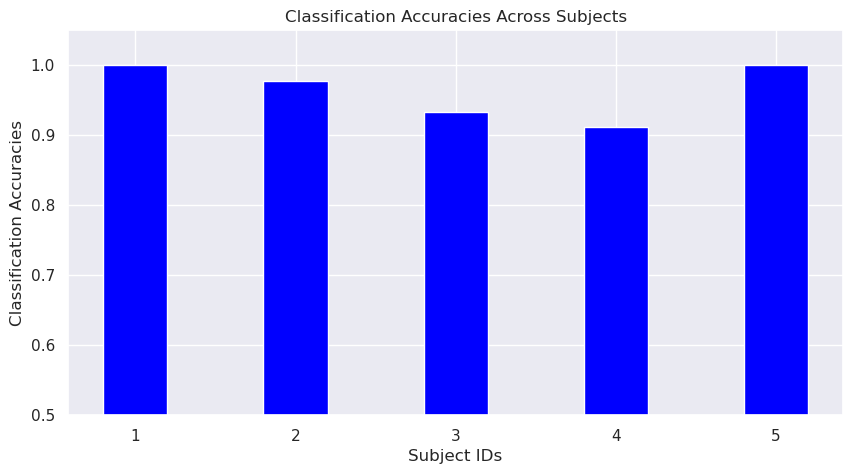

In [23]:
fig = plt.figure(figsize = (10, 5))
plt.bar([1,2,3,4,5], scores_all_subs, color ='blue',
        width = 0.4)
 
plt.xlabel("Subject IDs")
plt.ylim([0.5, 1.05])
plt.ylabel("Classification Accuracies")
plt.title("Classification Accuracies Across Subjects")
plt.show()

**Novel contribution:**<a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization. 

In [24]:
# Now code your nested cross-validation loops
np.random.seed(0)
subjects_exercise_6 = [1,2,3]

# Save results for all subjects
clf_accuracy_all_subjects, clf_Cs_all_subjects = [], []

# Loop through subjects
for sub in subjects_exercise_6:
    # Load data, labels, and run_ids for this subject
    fbold, flabels, frun_ids = load_single_subject_data(sub, "PPA")
    
    clfScores, clfCs = [], []
    
    ps = PredefinedSplit(frun_ids)
    # Create outer loop: Split data & labels into training and testing sets
    for train, test in ps.split():
        
        train_run_ids = frun_ids[train]
        
        train_data = fbold[train, :]
        test_data = fbold[test, :]
        
        train_label = flabels[train]
        test_label = flabels[test]
        
        # Create another split to divide training data into training/validation for inner loop
        sp_train = PredefinedSplit(train_run_ids)
        
        # Use grid search over the parameters you want to optimize
        parameters = {'C':[10e-2, 10e-1, 10e0, 10e1]}
        inner_clf = GridSearchCV(
        LogisticRegression(penalty='l2'),
        parameters,
        cv=sp_train,
        return_train_score=True)
        
        inner_clf.fit(train_data, train_label)
        
        # Grab the best parameter
        C_best_i = inner_clf.best_params_['C']
        clfCs.append(C_best_i)

        # Train the classifier using all training data and the best hyperparameters
        classifier = LogisticRegression(penalty='l2', C=C_best_i)
        clfs = classifier.fit(train_data, train_label)
        
        # Score the classifier on the test data and save
        score = clfs.score(test_data, test_label)
        clfScores.append(score)
    
    # Save results for this subject
    clf_accuracy_all_subjects.append(clfScores)
    clf_Cs_all_subjects.append(clfCs)

Loaded sub-01
Processing Start ...
Loaded PPA mask
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
sub-01 data has 930 TRs and 2504 voxels
Expected blocks: 45; Resampled blocks: 45
Loaded sub-02
Processing Start ...
Loaded PPA mask
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-02/preprocessed/loc/sub-02_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-02/preprocessed/loc/sub-02_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-02/preprocessed/loc/sub-02_filtered2_d1_firstExampleFunc_r3.nii
sub-02 data has 933 TRs and 3185 voxels
Expected blocks: 45; Resampled blocks: 45
Loaded sub-03


In [25]:
# Report the results
print(f'Results for exercise 6 but with Logistic Regression')
for s, subject in enumerate(subjects_exercise_6):
    print(f'Sub-{subject:02d} C:{clf_Cs_all_subjects[s]}, accuracy (mean,std): {np.mean(clf_accuracy_all_subjects[s])}, {np.std(clf_accuracy_all_subjects[s])}')
    

Results for exercise 6 but with Logistic Regression
Sub-01 C:[0.1, 0.1, 0.1], accuracy (mean,std): 0.7333333333333333, 0.0
Sub-02 C:[100.0, 0.1, 0.1], accuracy (mean,std): 0.9333333333333332, 0.05443310539518172
Sub-03 C:[0.1, 0.1, 0.1], accuracy (mean,std): 0.8666666666666667, 0.14401645996461915


Results for exercise 6 (with SVC)  
Sub-01 C:[0.1, 0.1, 0.1], accuracy (mean,std): 0.7111111111111111, 0.03142696805273544  
Sub-02 C:[0.1, 0.1, 0.1], accuracy (mean,std): 0.9333333333333332, 0.05443310539518172  
Sub-03 C:[0.1, 0.1, 0.1], accuracy (mean,std): 0.7777777777777778, 0.1911627837120584  

The logistic regression classifier showed very slightly higher accuracy although with a higher standard deviation than the SVC classifier.

## Contributions <a id="contributions"></a> 

M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 02/2018  
T. Meissner minor edits  
H. Zhang added random label and regularization exercises, change to PredefinedSplit, use normalized data, add solutions, other edits.  
M. Kumar re-organized the sections and added section context.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis incorporated comments from cmhn-s19   
A.K. Sahoo updated code, links, and added hyperparameter values for better understanding.    
M. Kumar updated notebook 01/2021.     
T. Yates made edits for cmhn_s21.  
E. Busch edits for cmhn_s22, cmhn_s23.